## Librerías

*Keras*

In [3]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import gzip
import tensorflow as tf


*Sklearn*

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

*Datos + Viz*

In [ ]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from matplotlib import image as mpimage
import seaborn as sns

In [6]:
from PIL import Image
import os
import uuid


## Ficheros

In [7]:
calc_train = pd.read_csv('../../artifacts/data/calc_case_description_train_set.csv')
calc_test = pd.read_csv('../../artifacts/data/calc_case_description_test_set.csv')
mass_train = pd.read_csv('../../artifacts/data/mass_case_description_train_set.csv')
mass_test = pd.read_csv('../../artifacts/data/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('../../artifacts/data/dicom_info.csv')

In [8]:
calc_train.head(1)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...


In [9]:
len(calc_train)

1546

In [10]:
dicom_df.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


### Filtrado y limpieza de imágenes

### Rutas

Las rutas correctas a la imágenes están en el fichero Dicom. Por ello, hay que obtener las rutas correctas de dicom, y después aplicarlas al resto de ficheros de test y entrenamiento

In [11]:
#función para reemplazar rutas:

def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [12]:
# def plot_smaples(sample, row=15, col=15):
#     plt.figure(figsize=(row, col))
#     for i, file in enumerate(sample[0:5]):
#         cropped_images_show = PIL.Image.open(file)
#         gray_img= cropped_images_show.convert("L")
#         plt.subplot(1,5,i+1)
#         plt.imshow(gray_img, cmap='gray')
#         plt.axis('off')
#     plt.show()

# obtener las rutas de dicom: Se filtra para los tres tipos de imágenes y se guardan en series
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

#Ruta correcta
correct_dir = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg"

# Reemplazar ruta para cropped_images
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) #comprobar ruta


# Reemplazar ruta para full_mammogram .
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])  #comprobar ruta

# Reemplazar ruta para roi_mask
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])  #comprobar ruta

Cropped Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [13]:
# Se crean diccionarios donde:
# - La clave es una parte del nombre del archivo extraída de la ruta (el elemento en la posición [10] al hacer .split('/')).
# - El valor es la ruta completa.

def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[10]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [14]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [15]:
# Extraer una parte del nombre de imagen desde las columnas 11, 12 y 13 (que contienen rutas)
# Usar *_dict para buscar la ruta real y correcta de la imagen
# Sustituir la ruta en el DataFrame
# Si no encuentra la imagen en el diccionario, poner None

def fix_image_path(data):
    """modifica rutas dicom a las imagenes correctas"""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 12] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

In [16]:
fix_image_path(mass_train)
fix_image_path(mass_test)
fix_image_path(calc_train)
fix_image_path(calc_test)

In [17]:
#Verificar que las rutas se han modificado correctamente:

def check_image_paths(df, name='DataFrame', cols=['image file path', 'cropped image file path', 'ROI mask file path'], n=3):
    print(f"\n🔍 Verificando {name}")
    for col in cols:
        print(f"\n📂 Columna: {col}")
        for i, path in enumerate(df[col].head(n)):
            print(f"[{i}] Ruta: {path}")
            if path and os.path.exists(path):
                try:
                    img = Image.open(path)
                    img.verify()  # Solo comprueba que es una imagen válida
                    print(f"✅ Imagen válida.")
                except Exception as e:
                    print(f"❌ Error al abrir la imagen: {e}")
            else:
                print("❌ Ruta vacía o no existe.")


check_image_paths(mass_train, name='mass_train')
check_image_paths(mass_test, name='mass_test')
check_image_paths(calc_train, name='calc_train')
check_image_paths(calc_test, name='calc_test')



🔍 Verificando mass_train

📂 Columna: image file path
[0] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
✅ Imagen válida.
[1] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
✅ Imagen válida.
[2] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg
✅ Imagen válida.

📂 Columna: cropped image file path
[0] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg
✅ Imagen válida.
[1] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
✅ Imagen válida.
[2] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850

Faltan algunas imágenes al menos de calc_test. Verificar posteriormente

## Análisis del dataset

### Revisión general:

In [18]:
print("Calc Train shape:", calc_train.shape)
print("Calc Test shape:", calc_test.shape)
print("Mass Train shape:", mass_train.shape)
print("Mass Test shape:", mass_test.shape)

print("\nCalc Train columns:")
print(calc_train.columns)

print("\nMass Train columns:")
print(mass_train.columns)


Calc Train shape: (1546, 14)
Calc Test shape: (326, 14)
Mass Train shape: (1318, 14)
Mass Test shape: (378, 14)

Calc Train columns:
Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

Mass Train columns:
Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')


In [19]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

def display_images(dataset, image_column='image file path', title_column='pathology', number=5):
    """Displays images from dataset, handling missing files and converting formats."""
    
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        if index >= number:  # Just in case
            break

        image_path = row.get(image_column, None)
        
        # Validar existencia del archivo
        if image_path is None or not os.path.exists(image_path):
            print(f"Archivo no encontrado o ruta inválida: {image_path}")
            continue
        
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Error al leer la imagen: {image_path}")
            continue
        
        # Convertir BGR a RGB si es necesario
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(str(row.get(title_column, 'Sin título')))
        ax.axis('off')
        print(np.array(image).shape)
    
    plt.tight_layout()
    plt.show()


Full Mammograms:



C:\Users\swatc\AppData\Local\Temp\ipykernel_15600\4250767249.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_title(str(row.get(title_column, 'Sin título')))


(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


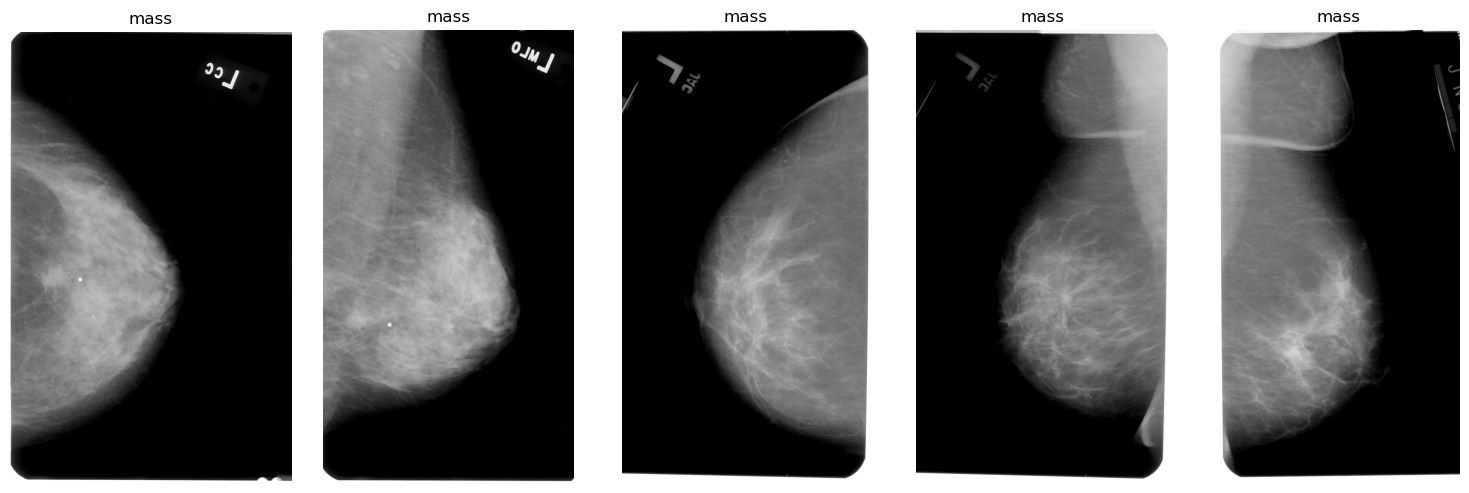

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


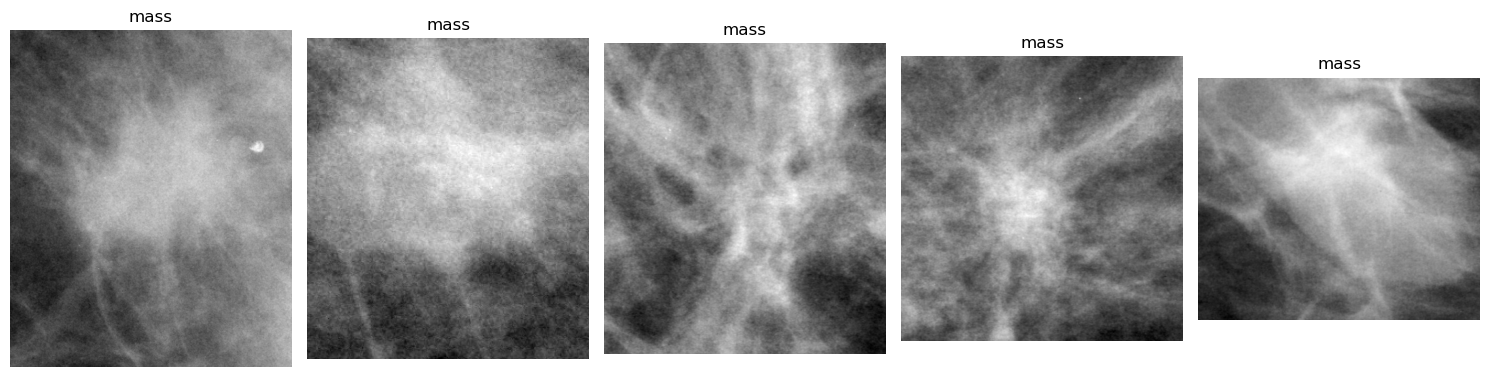

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


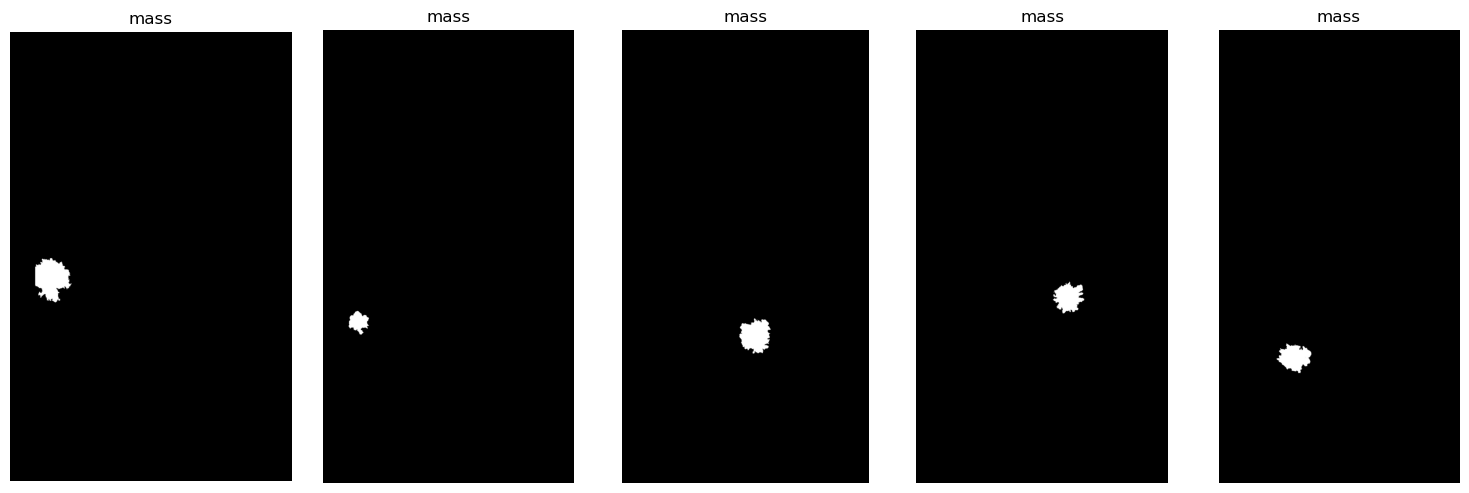

In [20]:
print('Full Mammograms:\n')
display_images(mass_train, 'image file path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped image file path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI mask file path', 5)

Unificar DataFrames

In [21]:
calc = pd.concat([calc_train, calc_test], ignore_index=True)
mass = pd.concat([mass_train, mass_test], ignore_index=True)

In [22]:
# Añadir la columna 'type' antes de unirlos
calc['type'] = 'calc'
mass['type'] = 'mass'

# Unir los dos DataFrames
df = pd.concat([calc, mass], ignore_index=True)

Corregir nombres de las columnas

In [23]:
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()  # elimina espacios al inicio y fin
        .str.lower()  # todo en minúsculas
        .str.replace(' ', '_')  # espacios por guiones bajos
    )
    return df


df = clean_column_names(df)

In [24]:
print(df.columns)

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'calc_type', 'calc_distribution',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'roi_mask_file_path', 'type',
       'breast_density', 'mass_shape', 'mass_margins'],
      dtype='object')


### Análisis exploratorio:

In [25]:
print("Total casos de calcificación:", (df['type'] == 'calc').sum())
print("Total casos de masa:", (df['type'] == 'mass').sum())

Total casos de calcificación: 1872
Total casos de masa: 1696


In [26]:
print("Calc_pathology:", calc['pathology'].unique())
print("Mass_pathology:", mass['pathology'].unique())

Calc_pathology: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']
Mass_pathology: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']


In [27]:
df['pathology'] = df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

In [28]:
pivot = pd.pivot_table(df, 
                       index='type', 
                       columns='pathology', 
                       aggfunc='size', 
                       fill_value=0)

print(pivot)


pathology  BENIGN  MALIGNANT
type                        
calc         1199        673
mass          912        784


Comprobar si las imágenes existen o si están correptas

In [29]:
def find_corrupt_images(df, cols=['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']):
    corrupt_report = []

    for col in cols:
        print(f"\n🔍 Verificando columna: {col}")
        for idx, path in df[col].items():
            if not path or not os.path.exists(path):
                print(f"❌ Ruta inexistente en índice {idx}: {path}")
                corrupt_report.append((idx, col, path, 'Ruta inexistente'))
                continue

            try:
                with Image.open(path) as img:
                    img.load()
            except Exception as e:
                print(f"❌ Imagen corrupta en índice {idx}: {path} — Error: {e}")
                corrupt_report.append((idx, col, path, str(e)))

    if corrupt_report:
        print(f"\n⚠️ Se encontraron {len(corrupt_report)} errores en imágenes.")
    else:
        print("\n✅ Todas las imágenes están en buen estado.")
    
    return corrupt_report


In [30]:
corrupt = find_corrupt_images(df)


🔍 Verificando columna: image_file_path
❌ Ruta inexistente en índice 1546: None
❌ Ruta inexistente en índice 1547: None
❌ Ruta inexistente en índice 1548: None
❌ Ruta inexistente en índice 1549: None
❌ Ruta inexistente en índice 1550: None
❌ Ruta inexistente en índice 1551: None
❌ Ruta inexistente en índice 1552: None
❌ Ruta inexistente en índice 1553: None
❌ Ruta inexistente en índice 1554: None
❌ Ruta inexistente en índice 1555: None
❌ Ruta inexistente en índice 1556: None
❌ Ruta inexistente en índice 1557: None
❌ Ruta inexistente en índice 1558: None
❌ Ruta inexistente en índice 1559: None
❌ Ruta inexistente en índice 1560: None
❌ Ruta inexistente en índice 1561: None
❌ Ruta inexistente en índice 1562: None
❌ Ruta inexistente en índice 1563: None
❌ Ruta inexistente en índice 1564: None
❌ Ruta inexistente en índice 1565: None
❌ Ruta inexistente en índice 1566: None
❌ Ruta inexistente en índice 1567: None
❌ Ruta inexistente en índice 1568: None
❌ Ruta inexistente en índice 1569: None


Faltan 606 imágenes ("None", pero las que sí tiene ruta funcionan correctamente)

In [31]:
# Ver filas con al menos una ruta vacía, nula o con "None"
missing_paths = df[df[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].map(lambda x: pd.isnull(x) or x == "None").any(axis=1)]

print("Rutas faltantes:", missing_paths.shape[0])



Rutas faltantes: 327


In [32]:
# Mostrar las filas de calc donde faltan rutas
missing_paths_details = missing_paths[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']]

print("Detalles de rutas faltantes en calc:")
print(missing_paths_details)

Detalles de rutas faltantes en calc:
                                        image_file_path  \
344   C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1216  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1546                                               None   
1547                                               None   
1548                                               None   
...                                                 ...   
1867                                               None   
1868                                               None   
1869                                               None   
1870  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1871                                               None   

                                cropped_image_file_path roi_mask_file_path  
344                                                None               None  
1216                                               None               None  
1546  C:/Users/swatc/De

In [33]:
# Crear una columna adicional para contar los valores faltantes por fila
missing_paths['missing_count'] = missing_paths[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].apply(lambda row: row.isnull().sum() + (row == "None").sum(), axis=1)

# Crear la tabla resumen (pivot) con el conteo de valores faltantes por cada columna
pivot_table = missing_paths[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].isnull().astype(int).sum()

# Mostrar la tabla con el número de imágenes faltantes en cada columna
print("Número de imágenes faltantes en cada columna:")
print(pivot_table)

# Crear una tabla con el número de filas que faltan 1, 2 o 3 valores
missing_count_summary = missing_paths['missing_count'].value_counts().sort_index()

# Mostrar el resumen del número de filas que tienen 1, 2 o 3 valores faltantes
print("\nNúmero de filas con 1, 2 o 3 valores faltantes:")
print(missing_count_summary)


Número de imágenes faltantes en cada columna:
image_file_path            282
cropped_image_file_path      2
roi_mask_file_path         322
dtype: int64

Número de filas con 1, 2 o 3 valores faltantes:
missing_count
1     48
2    279
Name: count, dtype: int64


C:\Users\swatc\AppData\Local\Temp\ipykernel_15600\234275630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_paths['missing_count'] = missing_paths[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].apply(lambda row: row.isnull().sum() + (row == "None").sum(), axis=1)


Eliminamos las filas en las que image_file_path está vacío, ya que si no existe esta imagen, que sería en input del modelo, no podemos usar estas líneas para entrenarlo

In [34]:
df = df[df['image_file_path'].notna() & (df['image_file_path'] != '')]

In [35]:
len(df)

3286

Dimensiones de imágenes

In [36]:
from PIL import Image

def check_image_sizes(df, col):
    sizes = []
    for path in df[col]:
        try:
            with Image.open(path) as img:
                sizes.append(img.size)
        except:
            sizes.append(None)
    return pd.Series(sizes).value_counts()

print(check_image_sizes(df, 'image_file_path'))


(3096, 4600)    9
(3040, 4640)    8
(4040, 5720)    8
(2911, 5491)    8
(4064, 5592)    8
               ..
(2856, 4616)    1
(2832, 4624)    1
(2976, 4520)    1
(2608, 4728)    1
(2386, 5011)    1
Name: count, Length: 2450, dtype: int64


### Mapeo

In [37]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0} 

In [38]:
#Mapeo de clases:
df['labels'] = df['pathology'].replace(class_mapper).infer_objects(copy=False)

#Extraer rutas válidas
full_images = np.array(df[df["image_file_path"].notna()]["image_file_path"].tolist())

#Extraer etiquetas
full_labels = np.array(df[df["image_file_path"].notna()]["labels"].tolist())



C:\Users\swatc\AppData\Local\Temp\ipykernel_15600\1093236136.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['labels'] = df['pathology'].replace(class_mapper).infer_objects(copy=False)


In [39]:
# convertir a series Pandas
full_labels_series = pd.Series(full_labels)

In [ ]:



print(df['pathology'].value_counts())

# Ajustar el estilo
sns.set(style="whitegrid", context="talk")

# Crear la paleta de rosas
rosa_palette = ['#FADADD', '#F28AB2', '#FF69B4', '#C71585']  # puedes ajustar los tonos a tu gusto

# Agrupar y contar
counts = df['pathology'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=rosa_palette[:len(counts.index)]
)

# Personalizar
plt.title('Número de casos por patología', fontsize=16, fontweight='bold')
plt.xlabel('Patología', fontsize=14)
plt.ylabel('Número de casos', fontsize=14)

# Añadir etiquetas encima de las barras
for i, v in enumerate(counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Data Augmentation

In [40]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

def resize_image(image_tensor, size=(224, 224)):
    return tf.image.resize(image_tensor, size)

def process_image(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_array = np.array(img)
            img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
            if len(img_tensor.shape) == 2:
                img_tensor = tf.stack([img_tensor]*3, axis=-1)
            img_tensor = resize_image(img_tensor)
            augmented = augment_image(img_tensor)
            augmented = tf.keras.preprocessing.image.array_to_img(augmented)
            return augmented
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [41]:
def augment_to_balance(images_0, images_1, output_dir):
    # Asegurar carpetas
    os.makedirs(os.path.join(output_dir, '0'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, '1'), exist_ok=True)

    len_0, len_1 = len(images_0), len(images_1)
    max_len = max(len_0, len_1)

    for img_path in images_0:
        img = process_image(img_path)
        if img:
            fname = f"{uuid.uuid4().hex}.jpg"
            img.save(os.path.join(output_dir, '0', fname))

    for img_path in images_1:
        img = process_image(img_path)
        if img:
            fname = f"{uuid.uuid4().hex}.jpg"
            img.save(os.path.join(output_dir, '1', fname))

    if len_0 < max_len:
        for _ in range(max_len - len_0):
            path = random.choice(images_0)
            img = process_image(path)
            if img:
                fname = f"{uuid.uuid4().hex}_aug.jpg"
                img.save(os.path.join(output_dir, '0', fname))

    if len_1 < max_len:
        for _ in range(max_len - len_1):
            path = random.choice(images_1)
            img = process_image(path)
            if img:
                fname = f"{uuid.uuid4().hex}_aug.jpg"
                img.save(os.path.join(output_dir, '1', fname))


In [42]:
destination_dir = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/AugmentedData"


benign_paths = [img for img, label in zip(full_images, full_labels) if label == 0]
malignant_paths = [img for img, label in zip(full_images, full_labels) if label == 1]

augment_to_balance(benign_paths, malignant_paths, destination_dir)


In [43]:
# Check the number of images in each class folder after merging
zero_class_count = len(os.listdir("C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/AugmentedData/0"))
one_class_count  = len(os.listdir("C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/AugmentedData/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

Number of images in class 0: 5793
Number of images in class 1: 5793


In [44]:
#Añadir estas nuevas imágenes al DF
destination_dir = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/AugmentedData"

image_paths = []
labels = []

# Recorrer subcarpetas '0' y '1'
for label_folder in ['0', '1']:
    folder_path = os.path.join(destination_dir, label_folder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Ajusta según extensión
                full_path = os.path.join(folder_path, filename)
                image_paths.append(full_path)
                labels.append(int(label_folder))  # 0 o 1

# Crear DataFrame
df_augmented = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(df_augmented.head())
print(f"Total imágenes: {len(df_augmented)}")


                                          image_path  label
0  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
1  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
2  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
3  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
4  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
Total imágenes: 11586


In [45]:
df_augmented.head()

,image_path,label
0,C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...,0
1,C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...,0
2,C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...,0
3,C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...,0
4,C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...,0


In [46]:
print(df.columns)
print(df_augmented.columns)

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'calc_type', 'calc_distribution',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'roi_mask_file_path', 'type',
       'breast_density', 'mass_shape', 'mass_margins', 'labels'],
      dtype='object')
Index(['image_path', 'label'], dtype='object')


In [47]:
#unificar nuevas imágenes con las originales
df_original_small = df[['image_file_path', 'labels']].copy()
df_original_small.rename(columns={'image_file_path': 'image_path', 'labels': 'label'}, inplace=True)

df_augmented_small = df_augmented[['image_path', 'label']].copy()

# Concatenar
df_completo = pd.concat([df_original_small, df_augmented_small], ignore_index=True)

print(df_completo.head())
print(f"Total imágenes combinadas: {len(df_completo)}")


                                          image_path  label
0  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      1
1  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      1
2  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
3  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
4  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...      0
Total imágenes combinadas: 14872


In [48]:
import tensorflow as tf
import pandas as pd


# Función para cargar y procesar imagen
def process_path(file_path, label):
    # Lee el archivo
    image = tf.io.read_file(file_path)
    # Decodifica JPEG (o PNG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensiona
    image = tf.image.resize(image, [224, 224])
    # Normaliza (opcional)
    image = image / 255.0
    return image, label

# Crear dataset a partir de paths y labels
paths = df_completo['image_path'].values
labels = df_completo['label'].values

# Convertir labels a tensores (enteros)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

# Crear dataset TensorFlow
full_dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
full_dataset = full_dataset.map(process_path)

# Mezclar y definir batch size
batch_size = 13
full_dataset = full_dataset.shuffle(buffer_size=len(df_completo), seed=50)


In [49]:
import pandas as pd

df_full_dataset = pd.DataFrame({
    "image_file_path": paths,
    "labels": labels
})

df_full_dataset.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/full_dataset.csv', index=False)


Train-test Split

In [50]:
# Dividir dataset (80%-15%-5%)
total_samples = len(df_completo)
train_size = int(0.8 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = full_dataset.skip(train_size + val_size).take(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Train samples: 11897
Validation samples: 2230
Test samples: 745


# Modelos

### VGG16 1.0

In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Cargar la base del modelo VGG16 sin la parte superior
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Congelar las capas convolucionales

# Construir el modelo
trymodel = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # ⚠️ SALIDA BINARIA
])

# Compilar el modelo
trymodel.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',  # ⚠️ PÉRDIDA BINARIA
    metrics=['accuracy']
)

trymodel.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [89]:
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)


Image shape: (13, 224, 224, 3)
Label shape: (13,)


In [92]:
# Entrenamiento
history = trymodel.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.5466 - loss: 0.7083 - val_accuracy: 0.6315 - val_loss: 0.6454
Epoch 2/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.6112 - loss: 0.6585 - val_accuracy: 0.6511 - val_loss: 0.6408
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - accuracy: 0.6297 - loss: 0.6477 - val_accuracy: 0.6297 - val_loss: 0.6374
Epoch 4/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.6388 - loss: 0.6353 - val_accuracy: 0.6651 - val_loss: 0.6040
Epoch 5/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.6423 - loss: 0.6349 - val_accuracy: 0.6754 - val_loss: 0.6146
Epoch 6/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.6419 - loss: 0.6283 - val_accuracy: 0.6716 - val_loss: 0.5980
Epoch 7/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.6400 - loss: 0.6287 - val_accuracy: 0.6679 - val_loss: 0.6181
Epoch 8/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 593s 1s/step - accuracy: 0.6507 - loss: 0.6256 - val_accu

In [93]:
#Evaluar

results = trymodel.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]*100:.2f}%")
print(f"Test Recall: {results[3]*100:.2f}%")


28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 975ms/step - accuracy: 0.6978 - loss: 0.5686

Test Loss: 0.5723
Test Accuracy: 68.44%


IndexError: list index out of range

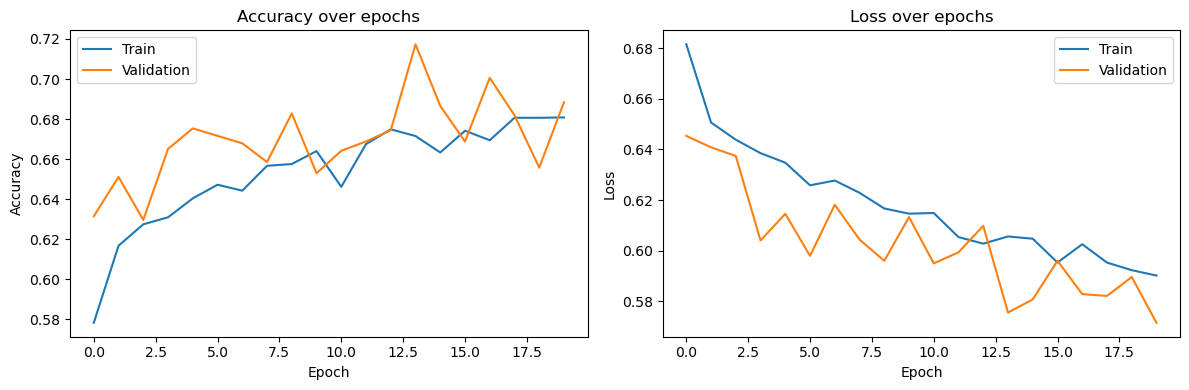

In [94]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## VGG16 2.0

In [144]:
#Class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extraer etiquetas del dataset de entrenamiento
y_train = []
for images, labels in train_dataset.unbatch():
    y_train.append(int(labels.numpy()))
y_train = np.array(y_train)

# Calcular los pesos de clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [145]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
import numpy as np

# Cargar el modelo base VGG16
base_model_2 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar parcialmente las primeras 10 capas
for layer in base_model_2.layers[:10]:
    layer.trainable = False
for layer in base_model_2.layers[10:]:
    layer.trainable = True

# Construir el modelo
trymodel_2 = models.Sequential([
    base_model_2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
trymodel_2.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Mostrar resumen
trymodel_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 13,044,993 (49.76 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [146]:
# ENTRENAMIENTO
history_2=trymodel_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights_dict
)


Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1462s 2s/step - accuracy: 0.4975 - loss: 0.7338 - precision_1: 0.4760 - recall_1: 0.5802 - val_accuracy: 0.4634 - val_loss: 0.6941 - val_precision_1: 0.4634 - val_recall_1: 1.0000
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1431s 2s/step - accuracy: 0.4818 - loss: 0.6932 - precision_1: 0.4677 - recall_1: 0.7843 - val_accuracy: 0.5191 - val_loss: 0.6931 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1452s 2s/step - accuracy: 0.5031 - loss: 0.6932 - precision_1: 0.4745 - recall_1: 0.5441 - val_accuracy: 0.4670 - val_loss: 0.6936 - val_precision_1: 0.4670 - val_recall_1: 1.0000
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1492s 2s/step - accuracy: 0.4787 - loss: 0.6940 - precision_1: 0.4774 - recall_1: 0.9201 - val_accuracy: 0.4737 - val_loss: 0.6934 - val_precision_1: 0.4737 - val_recall_1: 1.0000
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1526s 2s/step - accuracy: 0.4919 - loss: 0.6932 - precision_1: 0.4682 - 

In [147]:
#Evaluar

results = trymodel_2.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]*100:.2f}%")
print(f"Test Recall: {results[3]*100:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4704 - loss: 0.6934 - precision_1: 0.4704 - recall_1: 1.0000

Test Loss: 0.6935
Test Accuracy: 45.01%
Test Precision: 45.01%
Test Recall: 100.00%


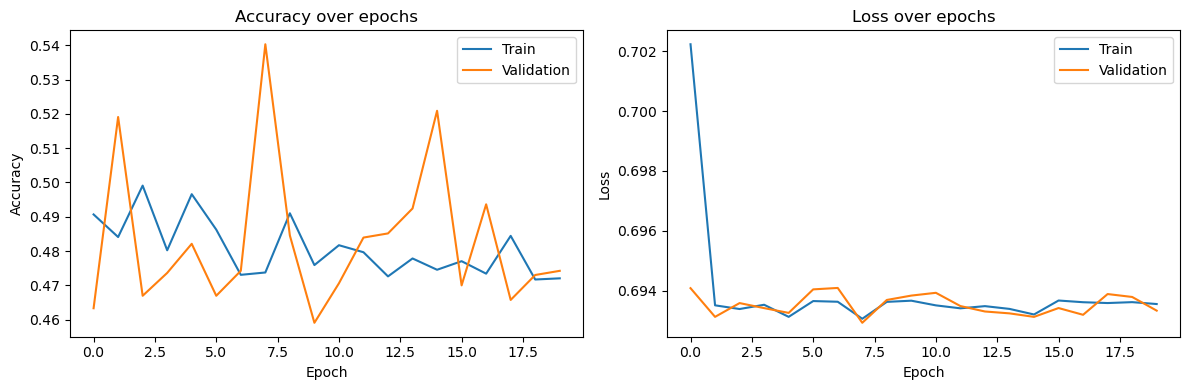

In [149]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train')
plt.plot(history_2.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train')
plt.plot(history_2.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ResNet 1.0

In [153]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Construcción del modelo
trymodel_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

# Compilación del modelo
trymodel_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [154]:
# Entrenamiento
history_3 = trymodel_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 514s 640ms/step - accuracy: 0.5654 - loss: 0.6922 - precision_4: 0.5579 - recall_4: 0.4944 - val_accuracy: 0.5506 - val_loss: 1.1032 - val_precision_4: 0.6985 - val_recall_4: 0.1193 - learning_rate: 1.0000e-04
Epoch 2/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 484s 678ms/step - accuracy: 0.6034 - loss: 0.6559 - precision_4: 0.5882 - recall_4: 0.4861 - val_accuracy: 0.5118 - val_loss: 0.7201 - val_precision_4: 0.4949 - val_recall_4: 0.9886 - learning_rate: 1.0000e-04
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 477s 667ms/step - accuracy: 0.6328 - loss: 0.6374 - precision_4: 0.6098 - recall_4: 0.6193 - val_accuracy: 0.5488 - val_loss: 2.1910 - val_precision_4: 0.7808 - val_recall_4: 0.0725 - learning_rate: 1.0000e-04
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 475s 667ms/step - accuracy: 0.6052 - loss: 0.6491 - precision_4: 0.5921 - recall_4: 0.5476 - val_accuracy: 0.6396 - val_loss: 0.6459 - val_precision_4: 0.6034 - val_recall_4: 0.7768 - learning_rate: 1.0000e-04


In [155]:
# Evaluación en test
results = trymodel_3.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.7208 - loss: 0.4817 - precision_4: 0.6644 - recall_4: 0.7716

Test Loss: 0.4940
Test Accuracy: 72.60%
Test Precision: 66.78%
Test Recall: 77.82%


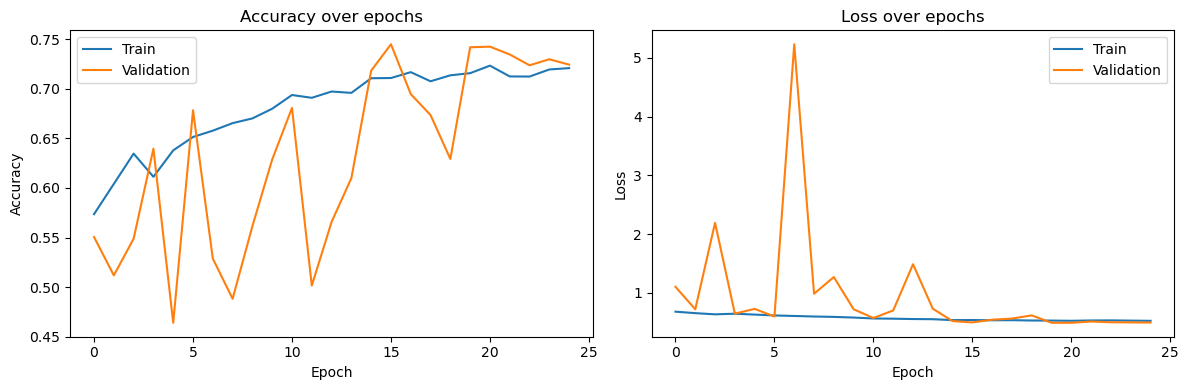

In [156]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train')
plt.plot(history_3.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy 72.60%: Es un resultado moderado, puede estar influida por un desequilibrio de clases

Precision 66.78%:
De todas las veces que el modelo predijo "positivo" (maligno), acertó el 66.78%. Puede suponer falsos positivos, lo cual es aceptable hasta cierto punto en medicina, pero no ideal.

Recall 77.82%:
De todos los casos realmente malignos, el modelo detectó correctamente el 77.82%.
Para nuestro propósito es muy importante minimizar los falsos negativos (casos malignos no detectados).

In [158]:
# Guardar el modelo en formato HDF5
# Guardar el modelo en formato nativo de Keras (.keras)
model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_3.keras"
trymodel_3.save(model_path)


# #Para Cargarlo sería así:
# from tensorflow.keras.models import load_model

# model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_3.keras"
# trymodel_3 = load_model(model_path)



In [51]:
#Mejora train test split:
# Mezclar el dataset antes de dividirlo
full_dataset = full_dataset.shuffle(buffer_size=total_samples, reshuffle_each_iteration=False)

# Ahora dividimos
train_dataset = full_dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = full_dataset.skip(train_size + val_size).take(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Efficientnetb0 1.0

In [166]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Cargar modelo base
base_model_4 = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar solo las primeras 150 capas (ajustable)
for layer in base_model_4.layers[:150]:
    layer.trainable = False
for layer in base_model_4.layers[150:]:
    layer.trainable = True

# Construcción del modelo
trymodel_4 = models.Sequential([
    base_model_4,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilación
trymodel_4.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


In [167]:
# Early stopping para evitar sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo
history_4 = trymodel_4.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stop]
)


Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 321s 351ms/step - accuracy: 0.4915 - loss: 0.7121 - precision_7: 0.4593 - recall_7: 0.5095 - val_accuracy: 0.4827 - val_loss: 0.7448 - val_precision_7: 0.4827 - val_recall_7: 1.0000
Epoch 2/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 247s 328ms/step - accuracy: 0.5292 - loss: 0.6955 - precision_7: 0.5073 - recall_7: 0.3802 - val_accuracy: 0.6069 - val_loss: 0.6870 - val_precision_7: 0.5768 - val_recall_7: 0.5654
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 237s 318ms/step - accuracy: 0.5319 - loss: 0.6933 - precision_7: 0.5083 - recall_7: 0.3920 - val_accuracy: 0.4682 - val_loss: 0.6992 - val_precision_7: 0.4671 - val_recall_7: 0.9948
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 236s 317ms/step - accuracy: 0.5373 - loss: 0.6911 - precision_7: 0.5077 - recall_7: 0.3863 - val_accuracy: 0.4609 - val_loss: 0.7086 - val_precision_7: 0.4606 - val_recall_7: 0.9987
Epoch 5/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 233s 313ms/step - accuracy: 0.5380 - loss: 0.6927 - precision_7: 0.5151 

In [168]:
# Evaluar en el set de test
results_4 = trymodel_4.evaluate(test_dataset)
print(f"\nTest Loss: {results_4[0]:.4f}")
print(f"Test Accuracy: {results_4[1]*100:.2f}%")
print(f"Test Precision: {results_4[2]*100:.2f}%")
print(f"Test Recall: {results_4[3]*100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.5891 - loss: 0.6883 - precision_7: 0.5795 - recall_7: 0.5038

Test Loss: 0.6847
Test Accuracy: 61.71%
Test Precision: 61.54%
Test Recall: 54.34%


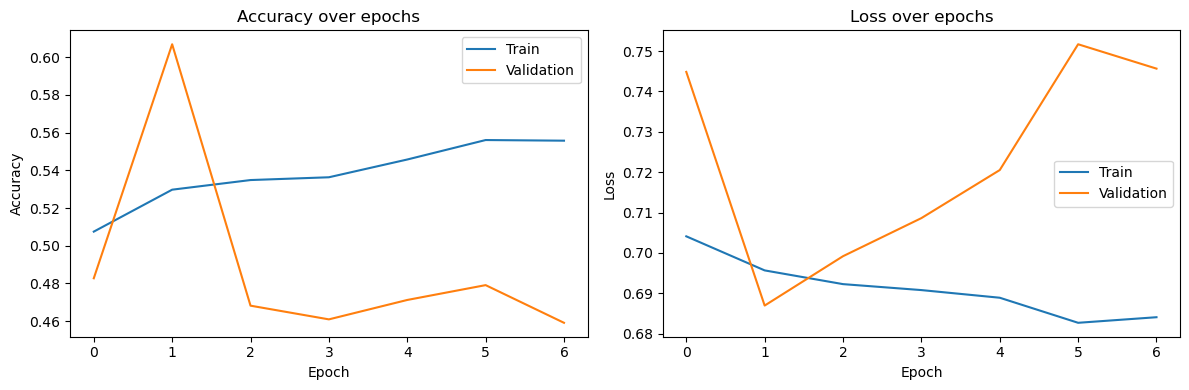

In [169]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train')
plt.plot(history_4.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train')
plt.plot(history_4.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### maiurilorenzo/CBIS-DDSM-CNN 1.0

modelo específico para tratamieno de mamografías

In [174]:
from huggingface_hub import hf_hub_download
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Descarga y carga del modelo preentrenado
repo_id = "maiurilorenzo/CBIS-DDSM-CNN"

# Modelo
model_path = hf_hub_download(repo_id=repo_id, filename="CNN_model.h5")
trymodel_5 = tf.keras.models.load_model(model_path)

# Preprocessing info
preprocessing_path = hf_hub_download(repo_id=repo_id, filename="preprocessing.json")
with open(preprocessing_path, "r") as f:
    preprocessing_info = json.load(f)

target_size = tuple(preprocessing_info["target_size"])

# Función de preprocesamiento de imágenes
def preprocess_image(image):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Función para one-hot encoding
def one_hot_encode(y):
    return tf.one_hot(y, depth=2)

# Aplicar preprocesamiento y one-hot encoding
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset_with_onehot(dataset):
    return dataset.map(
        lambda x, y: (preprocess_image(x), one_hot_encode(y)),
        num_parallel_calls=AUTOTUNE
    )

# Preprocesar datasets (usando los que ya tienes)
train_dataset_preprocessed = preprocess_dataset_with_onehot(train_dataset)
val_dataset_preprocessed = preprocess_dataset_with_onehot(val_dataset)
test_dataset_preprocessed = preprocess_dataset_with_onehot(test_dataset)

# Compilar el modelo
trymodel_5.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [175]:
# Entrenamiento
history_5 = trymodel_5.fit(
    train_dataset_preprocessed,
    epochs=30,
    validation_data=val_dataset_preprocessed,
    callbacks=[early_stop]
)

Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step - accuracy: 0.5328 - loss: 3.5553 - precision_9: 0.5328 - recall_9: 0.5328 - val_accuracy: 0.5191 - val_loss: 704.0380 - val_precision_9: 0.5191 - val_recall_9: 0.5191
Epoch 2/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 55s 53ms/step - accuracy: 0.5333 - loss: 1.3690 - precision_9: 0.5333 - recall_9: 0.5333 - val_accuracy: 0.4991 - val_loss: 1.5279 - val_precision_9: 0.4991 - val_recall_9: 0.4991
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.5476 - loss: 1.0425 - precision_9: 0.5476 - recall_9: 0.5476 - val_accuracy: 0.5803 - val_loss: 0.8959 - val_precision_9: 0.5803 - val_recall_9: 0.5803
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 54s 53ms/step - accuracy: 0.5350 - loss: 0.9201 - precision_9: 0.5350 - recall_9: 0.5350 - val_accuracy: 0.5494 - val_loss: 0.8642 - val_precision_9: 0.5494 - val_recall_9: 0.5494
Epoch 5/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.5491 - loss: 0.8412 - precision_9: 0.5491 - recall

In [176]:
# Evaluación
results = trymodel_5.evaluate(test_dataset_preprocessed)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]*100:.2f}%")
print(f"Test Recall: {results[3]*100:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5674 - loss: 0.7039 - precision_9: 0.5674 - recall_9: 0.5674

Test Loss: 0.6830
Test Accuracy: 57.35%
Test Precision: 57.35%
Test Recall: 57.35%


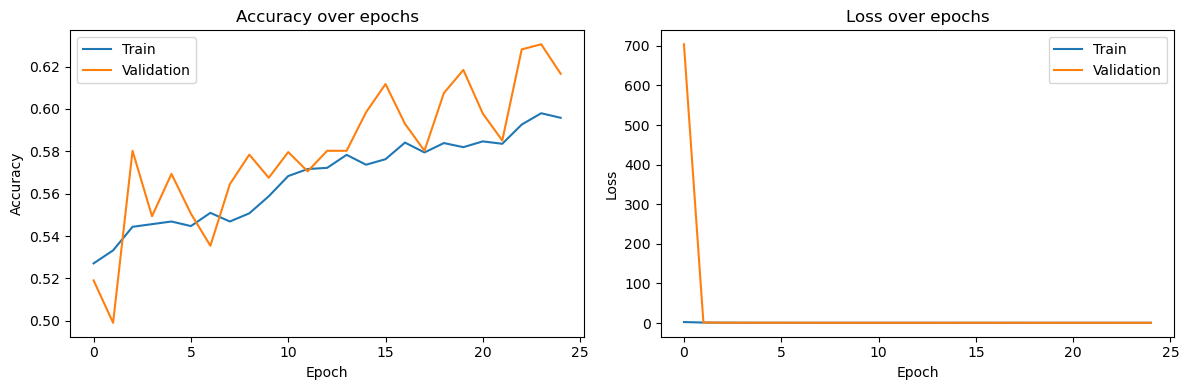

In [177]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'], label='Train')
plt.plot(history_5.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'], label='Train')
plt.plot(history_5.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### maiurilorenzo/CBIS-DDSM-CNN 2.0 (cambiamos learning rate y class weight)

In [179]:
from huggingface_hub import hf_hub_download
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json

# Descarga el modelo desde Hugging Face Hub
repo_id = "maiurilorenzo/CBIS-DDSM-CNN"
model_path = hf_hub_download(repo_id=repo_id, filename="CNN_model.h5")
trymodel_6 = tf.keras.models.load_model(model_path)

# Descarga la información de preprocesamiento
preprocessing_path = hf_hub_download(repo_id=repo_id, filename="preprocessing.json")
with open(preprocessing_path, "r") as f:
    preprocessing_info = json.load(f)

target_size = tuple(preprocessing_info["target_size"])

# Preprocesamiento de las imágenes
def preprocess_image(image):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def one_hot_encode(y):
    return tf.one_hot(y, depth=2)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess_with_augmentation(image, label):
    image = preprocess_image(image)
    image = data_augmentation(image)
    label = one_hot_encode(label)
    return image, label

# Dataset preprocesado
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_preprocessed = train_dataset.map(
    preprocess_with_augmentation,
    num_parallel_calls=AUTOTUNE
)

val_dataset_preprocessed = val_dataset.map(
    lambda x, y: (preprocess_image(x), one_hot_encode(y)),
    num_parallel_calls=AUTOTUNE
)

test_dataset_preprocessed = test_dataset.map(
    lambda x, y: (preprocess_image(x), one_hot_encode(y)),
    num_parallel_calls=AUTOTUNE
)

# Fine-tuning: descongelar las últimas capas
for layer in trymodel_6.layers[:-3]:
    layer.trainable = False
for layer in trymodel_6.layers[-3:]:
    layer.trainable = True

# Cálculo de class_weight
# Extraemos las etiquetas de train_dataset
labels_train = []
for _, label in train_dataset.unbatch():
    labels_train.append(int(label.numpy()))
labels_train = np.array(labels_train)

# Calculamos las clases y pesos
classes = np.unique(labels_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels_train
)
class_weight_dict = dict(zip(classes, class_weights))
print("Pesos de clase:", class_weight_dict)

# Compilación
trymodel_6.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


Pesos de clase: {0: 0.9569752281616688, 1: 1.0470756062767475}


In [180]:
# Entrenamiento
history_6 = trymodel_6.fit(
    train_dataset_preprocessed,
    epochs=30,
    validation_data=val_dataset_preprocessed,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.5146 - loss: 1.1649 - precision_10: 0.5146 - recall_10: 0.5146 - val_accuracy: 0.5288 - val_loss: 0.7006 - val_precision_10: 0.5288 - val_recall_10: 0.5288 - learning_rate: 0.0010
Epoch 2/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.5135 - loss: 0.7056 - precision_10: 0.5135 - recall_10: 0.5135 - val_accuracy: 0.5106 - val_loss: 0.6946 - val_precision_10: 0.5106 - val_recall_10: 0.5106 - learning_rate: 0.0010
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - accuracy: 0.5141 - loss: 0.6976 - precision_10: 0.5141 - recall_10: 0.5141 - val_accuracy: 0.5251 - val_loss: 0.6925 - val_precision_10: 0.5251 - val_recall_10: 0.5251 - learning_rate: 0.0010
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5145 - loss: 0.6941 - precision_10: 0.5145 - recall_10: 0.5145 - val_accuracy: 0.5100 - val_loss: 0.6932 - val_precision_10: 0.5100 - val_recall_10: 0.5100 - learning_rate: 0.0010
Epoch 5

In [181]:
# Evaluación
results = trymodel_6.evaluate(test_dataset_preprocessed)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]*100:.2f}%")
print(f"Test Recall: {results[3]*100:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.4902 - loss: 0.6935 - precision_10: 0.4902 - recall_10: 0.4902

Test Loss: 0.6931
Test Accuracy: 50.64%
Test Precision: 50.64%
Test Recall: 50.64%


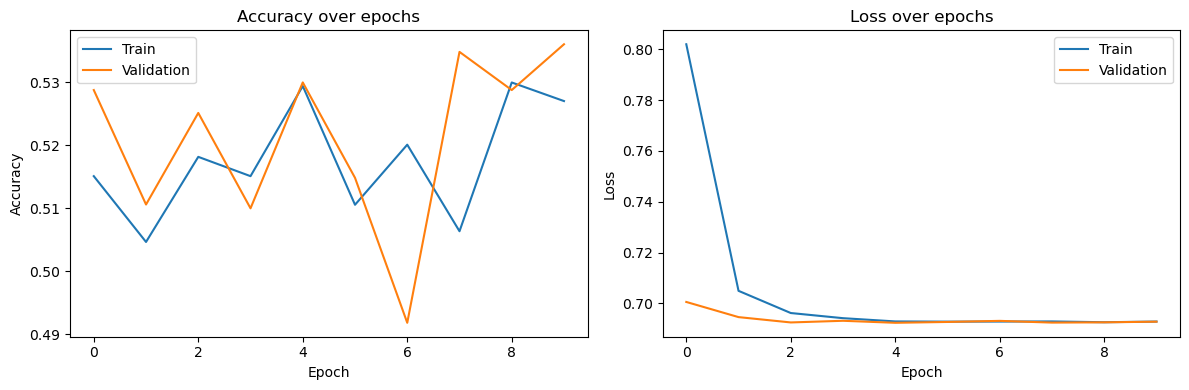

In [182]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_6.history['accuracy'], label='Train')
plt.plot(history_6.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_6.history['loss'], label='Train')
plt.plot(history_6.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

MAXIMIZAR RECALL: 

✅ 1. Cambiar el umbral de clasificación (threshold)
Ahora el modelo predice “Cancer” si probabilidad >= 0.5. Si bajamos ese umbral (por ejemplo a 0.4 o 0.3), detectaremos más positivos.

✅ 2. Ajustar la función de pérdida
Podemos usar una pérdida que penalice más los falsos negativos, como la Focal Loss o la Weighted Binary Crossentropy con mayor peso para la clase positiva.

✅ 3. Usar una métrica de optimización enfocada en recall
Aunque la métrica de validación por defecto es val_loss, puedes monitorizar val_recall para el EarlyStopping

✅ 4. Data Augmentation (específico para la clase minoritaria)
Si hay pocas imágenes de cáncer, podemos aplicar más augmentations para la clase minoritaria (oversampling).

✅ 5. Class Weights
Ya estamos usando class weights, pero podemos forzar un mayor peso aún para la clase positiva

### maiurilorenzo/CBIS-DDSM-CNN 3.0

In [183]:
from huggingface_hub import hf_hub_download
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json

# Descarga el modelo desde Hugging Face Hub
repo_id = "maiurilorenzo/CBIS-DDSM-CNN"
model_path = hf_hub_download(repo_id=repo_id, filename="CNN_model.h5")
trymodel_7 = tf.keras.models.load_model(model_path)

# Descarga la información de preprocesamiento
preprocessing_path = hf_hub_download(repo_id=repo_id, filename="preprocessing.json")
with open(preprocessing_path, "r") as f:
    preprocessing_info = json.load(f)

target_size = tuple(preprocessing_info["target_size"])

# Preprocesamiento de las imágenes
def preprocess_image(image):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def one_hot_encode(y):
    return tf.one_hot(y, depth=2)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess_with_augmentation(image, label):
    image = preprocess_image(image)
    image = data_augmentation(image)
    label = one_hot_encode(label)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_dataset_preprocessed = train_dataset.map(
    preprocess_with_augmentation,
    num_parallel_calls=AUTOTUNE
)
val_dataset_preprocessed = val_dataset.map(
    lambda x, y: (preprocess_image(x), one_hot_encode(y)),
    num_parallel_calls=AUTOTUNE
)
test_dataset_preprocessed = test_dataset.map(
    lambda x, y: (preprocess_image(x), one_hot_encode(y)),
    num_parallel_calls=AUTOTUNE
)

# Fine-tuning: descongelar las últimas capas
for layer in trymodel_7.layers[:-3]:
    layer.trainable = False
for layer in trymodel_7.layers[-3:]:
    layer.trainable = True

# Cálculo de class_weight (más peso para la clase positiva)
labels_train = []
for _, label in train_dataset.unbatch():
    labels_train.append(int(label.numpy()))
labels_train = np.array(labels_train)

classes = np.unique(labels_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels_train
)
# Aumentamos el peso de la clase positiva
class_weights[1] *= 1.5
class_weight_dict = dict(zip(classes, class_weights))
print("Pesos de clase:", class_weight_dict)

# Compilación
trymodel_7.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_recall', factor=0.5, patience=3, verbose=1, mode='max')


Pesos de clase: {0: 0.9460794844253491, 1: 1.5906573561281003}


In [184]:
# Entrenamiento
history_7 = trymodel_7.fit(
    train_dataset_preprocessed,
    epochs=30,
    validation_data=val_dataset_preprocessed,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.5044 - loss: 4.5309 - precision_11: 0.5044 - recall_11: 0.5044 - val_accuracy: 0.4833 - val_loss: 0.6935 - val_precision_11: 0.4833 - val_recall_11: 0.4833 - learning_rate: 1.0000e-04
Epoch 2/30


c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,precision_11,recall_11,val_accuracy,val_loss,val_precision_11,val_recall_11
  current = self.get_monitor_value(logs)
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,precision_11,recall_11,val_accuracy,val_loss,val_precision_11,val_recall_11,learning_rate.
  callback.on_epoch_end(epoch, logs)


678/678 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.5016 - loss: 0.9346 - precision_11: 0.5016 - recall_11: 0.5016 - val_accuracy: 0.5064 - val_loss: 0.6932 - val_precision_11: 0.5064 - val_recall_11: 0.5064 - learning_rate: 1.0000e-04
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.4877 - loss: 0.9385 - precision_11: 0.4877 - recall_11: 0.4877 - val_accuracy: 0.4652 - val_loss: 0.6974 - val_precision_11: 0.4652 - val_recall_11: 0.4652 - learning_rate: 1.0000e-04
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - accuracy: 0.4945 - loss: 0.9276 - precision_11: 0.4945 - recall_11: 0.4945 - val_accuracy: 0.4737 - val_loss: 0.6936 - val_precision_11: 0.4737 - val_recall_11: 0.4737 - learning_rate: 1.0000e-04
Epoch 5/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - accuracy: 0.4926 - loss: 0.9187 - precision_11: 0.4926 - recall_11: 0.4926 - val_accuracy: 0.4785 - val_loss: 0.6933 - val_precision_11: 0.4785 - val_recall_11: 0.4785 - learning_rate: 1.0000e-04
Epo

In [185]:
# Evaluación
results = trymodel_7.evaluate(test_dataset_preprocessed)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]*100:.2f}%")
print(f"Test Recall: {results[3]*100:.2f}%")

# Predicciones ajustando el umbral
threshold = 0.4
y_pred_probs = trymodel_7.predict(test_dataset_preprocessed)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_thresholded = (y_pred_probs[:, 1] >= threshold).astype(int)

# Métricas con umbral ajustado
from sklearn.metrics import classification_report
y_true_labels = []
for _, label in test_dataset.unbatch():
    y_true_labels.append(int(label.numpy()))
print("\nClasification Report (Threshold=0.4):")
print(classification_report(y_true_labels, y_pred_thresholded, target_names=['Normal', 'Cancer']))

43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.4977 - loss: 0.7168 - precision_11: 0.4977 - recall_11: 0.4977

Test Loss: 0.7193
Test Accuracy: 49.18%
Test Precision: 49.18%
Test Recall: 49.18%
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step

Clasification Report (Threshold=0.4):
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       298
      Cancer       0.46      1.00      0.63       253

    accuracy                           0.46       551
   macro avg       0.23      0.50      0.31       551
weighted avg       0.21      0.46      0.29       551



c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


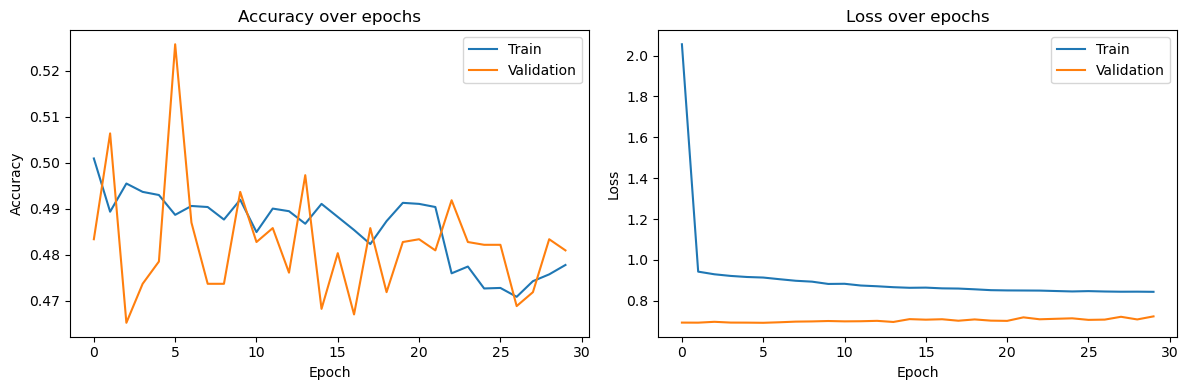

In [186]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_7.history['accuracy'], label='Train')
plt.plot(history_7.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_7.history['loss'], label='Train')
plt.plot(history_7.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### ResNet 2.0

Con Train/test mejorado

In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Construcción del modelo
trymodel_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

# Compilación del modelo
trymodel_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [188]:
# Entrenamiento
history_3 = trymodel_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 449s 604ms/step - accuracy: 0.5464 - loss: 0.6941 - precision_12: 0.5140 - recall_12: 0.4508 - val_accuracy: 0.5324 - val_loss: 1.3636 - val_precision_12: 0.8889 - val_recall_12: 0.0103 - learning_rate: 1.0000e-04
Epoch 2/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 421s 589ms/step - accuracy: 0.5986 - loss: 0.6625 - precision_12: 0.5764 - recall_12: 0.5213 - val_accuracy: 0.5064 - val_loss: 0.6858 - val_precision_12: 0.4861 - val_recall_12: 0.9987 - learning_rate: 1.0000e-04
Epoch 3/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 420s 589ms/step - accuracy: 0.6206 - loss: 0.6469 - precision_12: 0.5904 - recall_12: 0.6521 - val_accuracy: 0.5263 - val_loss: 2.7840 - val_precision_12: 0.9231 - val_recall_12: 0.0151 - learning_rate: 1.0000e-04
Epoch 4/30
678/678 ━━━━━━━━━━━━━━━━━━━━ 421s 589ms/step - accuracy: 0.6413 - loss: 0.6274 - precision_12: 0.6018 - recall_12: 0.6960 - val_accuracy: 0.5385 - val_loss: 1.8110 - val_precision_12: 0.8261 - val_recall_12: 0.0245 - learning_r

In [189]:
# Evaluación en test
results = trymodel_3.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 379ms/step - accuracy: 0.7770 - loss: 0.4370 - precision_12: 0.7449 - recall_12: 0.8256

Test Loss: 0.4270
Test Accuracy: 78.04%
Test Precision: 73.45%
Test Recall: 82.88%


Loss (pérdida) = 0.4270
Es la función objetivo que el modelo está minimizando. Un valor moderado, no muy bajo ni muy alto. Indica que el modelo tiene margen para mejorar, pero no está fallando completamente.

Accuracy (Precisión global) = 78.04%
El modelo clasifica correctamente alrededor del 78% de los ejemplos en el conjunto de test. Esto suena razonable para muchos problemas, pero depende mucho del contexto (dificultad, tipo de datos, etc.).

Precision (Precisión) = 73.45%
De todas las predicciones positivas que hizo el modelo, el 73.45% fueron correctas. En otras palabras, el modelo tiene un 26.55% de falsos positivos.
→ Esto indica que a veces el modelo marca casos como positivos cuando no lo son.

Recall (Sensibilidad) = 82.88%
De todos los casos que realmente son positivos, el modelo detecta el 82.88%. Esto es bastante bueno: pocos falsos negativos.

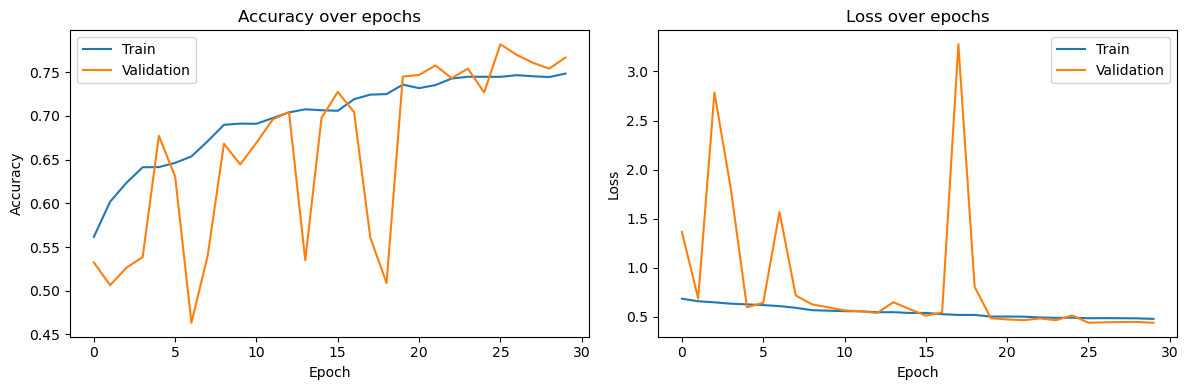

In [190]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train')
plt.plot(history_3.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [191]:
# Guardar el modelo en formato HDF5
# Guardar el modelo en formato nativo de Keras (.keras)
model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_8.keras"
trymodel_3.save(model_path)


# #Para Cargarlo sería así:
# from tensorflow.keras.models import load_model

# model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_8.keras"
# trymodel_8 = load_model(model_path)

2º prueba:

In [55]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Construcción del modelo
trymodel_8 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

# Compilación del modelo
trymodel_8.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
# Entrenamiento
history_8 = trymodel_8.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 685s 639ms/step - accuracy: 0.5567 - loss: 0.6890 - precision_2: 0.5339 - recall_2: 0.4820 - val_accuracy: 0.4807 - val_loss: 1.3852 - val_precision_2: 0.4803 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 621s 631ms/step - accuracy: 0.5835 - loss: 0.6671 - precision_2: 0.5829 - recall_2: 0.4898 - val_accuracy: 0.5368 - val_loss: 1.4108 - val_precision_2: 0.6333 - val_recall_2: 0.0539 - learning_rate: 1.0000e-04
Epoch 3/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step - accuracy: 0.6272 - loss: 0.6364 - precision_2: 0.6018 - recall_2: 0.6729 - val_accuracy: 0.5439 - val_loss: 0.9580 - val_precision_2: 0.7765 - val_recall_2: 0.0620 - learning_rate: 1.0000e-04
Epoch 4/30
916/916 ━━━━━━━━━━━━━━━━━━━━ 593s 609ms/step - accuracy: 0.6438 - loss: 0.6250 - precision_2: 0.6027 - recall_2: 0.7249 - val_accuracy: 0.6794 - val_loss: 0.6130 - val_precision_2: 0.6285 - val_recall_2: 0.8382 - learning_rate: 1.0000e-04
Ep

In [56]:
# Evaluación en test
results = trymodel_8.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")


58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 398ms/step - accuracy: 0.7114 - loss: 0.5333 - precision_2: 0.6542 - recall_2: 0.8583

Test Loss: 0.5410
Test Accuracy: 71.14%
Test Precision: 66.38%
Test Recall: 84.55%


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones de probabilidad
y_pred_prob = trymodel_8.predict(val_dataset)

# Convertir a etiquetas binarias (umbral 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Obtener las etiquetas verdaderas
y_true = np.concatenate([y for x, y in val_dataset], axis=0).astype(int)

172/172 ━━━━━━━━━━━━━━━━━━━━ 113s 364ms/step


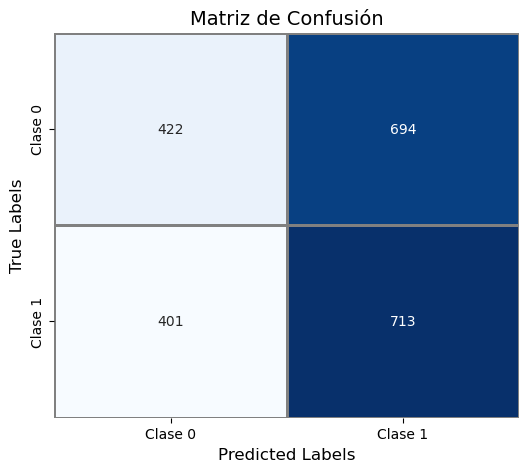

In [58]:
#Matriz confusion
cm = confusion_matrix(y_true, y_pred)

# Visualización con Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Matriz de Confusión', fontsize=14)
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()


In [59]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.38      0.44      1116
           1       0.51      0.64      0.57      1114

    accuracy                           0.51      2230
   macro avg       0.51      0.51      0.50      2230
weighted avg       0.51      0.51      0.50      2230



58/58 ━━━━━━━━━━━━━━━━━━━━ 76s 346ms/step


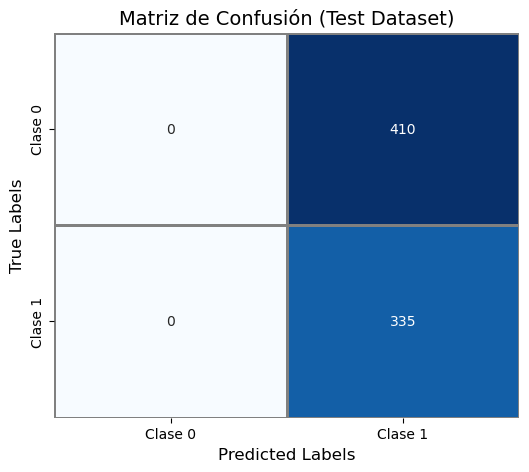

In [ ]:
# Predicciones del modelo
y_pred_prob = trymodel_8.predict(test_dataset)

# Convertir las probabilidades en etiquetas binarias
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Extraer las etiquetas verdaderas del test_dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Matriz de Confusión (Test Dataset)', fontsize=14)
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()


Probamos a mejorar:
Añadir más capas densas
Cambiar optimizador
Afinal umbral de clasificación
Aumentar patience del early stopping
Reducir tasa apendizaje despues de X epochs

In [61]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Construcción del modelo
trymodel_10 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilación del modelo
trymodel_10.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5

lr_scheduler = LearningRateScheduler(lr_schedule)

# Entrenamiento
history_8 = trymodel_10.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[early_stop, reduce_lr, lr_scheduler]
)


Epoch 1/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 646s 614ms/step - accuracy: 0.5590 - loss: 0.8866 - precision_3: 0.5418 - recall_3: 0.5540 - val_accuracy: 0.5175 - val_loss: 5.3459 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 619s 641ms/step - accuracy: 0.5753 - loss: 0.8167 - precision_3: 0.5608 - recall_3: 0.5626 - val_accuracy: 0.5300 - val_loss: 0.7588 - val_precision_3: 0.5748 - val_recall_3: 0.1583 - learning_rate: 1.0000e-04
Epoch 3/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 599s 619ms/step - accuracy: 0.6087 - loss: 0.7554 - precision_3: 0.5880 - recall_3: 0.5831 - val_accuracy: 0.5309 - val_loss: 1.6710 - val_precision_3: 1.0000 - val_recall_3: 0.0048 - learning_rate: 1.0000e-04
Epoch 4/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 602s 624ms/step - accuracy: 0.6044 - loss: 0.7468 - precision_3: 0.5849 - recall_3: 0.5866 - val_accuracy: 0.6121 - val_loss: 0.6930 - val_precision_3: 0.5590 - val_recall_3: 0.9189 - learning_rate: 1.0

In [62]:
# Evaluación en test
results = trymodel_10.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 399ms/step - accuracy: 0.7730 - loss: 0.4764 - precision_3: 0.7474 - recall_3: 0.8143

Test Loss: 0.4757
Test Accuracy: 77.32%
Test Precision: 74.80%
Test Recall: 79.61%


172/172 ━━━━━━━━━━━━━━━━━━━━ 108s 409ms/step


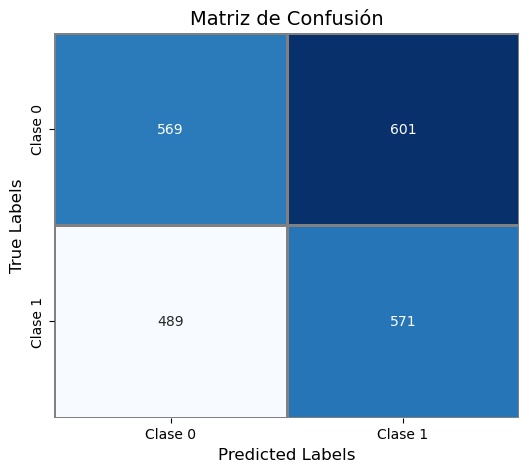

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones de probabilidad
y_pred_prob = trymodel_10.predict(val_dataset)

# Convertir a etiquetas binarias (umbral 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Obtener las etiquetas verdaderas
y_true = np.concatenate([y for x, y in val_dataset], axis=0).astype(int)
#Matriz confusion
cm = confusion_matrix(y_true, y_pred)

# Visualización con Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Matriz de Confusión', fontsize=14)
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()


58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step


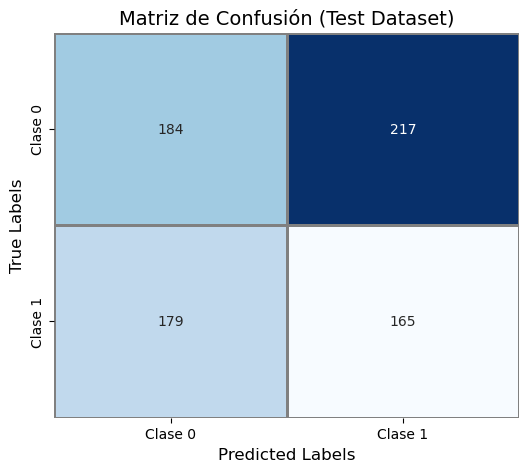

In [64]:
# Predicciones del modelo
y_pred_prob = trymodel_10.predict(test_dataset)

# Convertir las probabilidades en etiquetas binarias
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Extraer las etiquetas verdaderas del test_dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Matriz de Confusión (Test Dataset)', fontsize=14)
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()


In [65]:
model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_10.keras"
trymodel_10.save(model_path)

Probar un learning rate un poco más bajo para permitir un aprendizaje más fino.
Usar focal loss en vez de binary crossentropy (priorizar recall y precisión)
Simplificar la arquitectura un poco para que no “mate” la capacidad de generalización.
Ajustar callbacks a un patience un poco mayor

In [66]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 40 capas
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Construcción del modelo
trymodel_11 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compilación del modelo
trymodel_11.compile(
    optimizer=Adam(learning_rate=5e-5),  # un pelín más bajo para afinar
    loss='binary_crossentropy',          # seguimos con binary_crossentropy (o podríamos usar focal_loss)
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Entrenamiento
history_11 = trymodel_11.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 702s 662ms/step - accuracy: 0.6011 - loss: 0.7298 - precision_4: 0.5809 - recall_4: 0.5766 - val_accuracy: 0.5184 - val_loss: 0.8697 - val_precision_4: 0.6571 - val_recall_4: 0.1019 - learning_rate: 5.0000e-05
Epoch 2/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 627s 650ms/step - accuracy: 0.6202 - loss: 0.6919 - precision_4: 0.6217 - recall_4: 0.5802 - val_accuracy: 0.4879 - val_loss: 1.1310 - val_precision_4: 0.4879 - val_recall_4: 0.9972 - learning_rate: 5.0000e-05
Epoch 3/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 630s 648ms/step - accuracy: 0.6388 - loss: 0.6615 - precision_4: 0.6250 - recall_4: 0.6002 - val_accuracy: 0.5269 - val_loss: 1.1923 - val_precision_4: 1.0000 - val_recall_4: 0.0204 - learning_rate: 5.0000e-05
Epoch 4/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 616s 644ms/step - accuracy: 0.6376 - loss: 0.6593 - precision_4: 0.6303 - recall_4: 0.6031 - val_accuracy: 0.5291 - val_loss: 2.6950 - val_precision_4: 1.0000 - val_recall_4: 0.0019 - learning_rate: 5.0000e-05


In [67]:
# Evaluación en test
results = trymodel_11.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 394ms/step - accuracy: 0.8275 - loss: 0.4028 - precision_4: 0.9000 - recall_4: 0.7382

Test Loss: 0.4312
Test Accuracy: 79.46%
Test Precision: 86.87%
Test Recall: 69.35%


172/172 ━━━━━━━━━━━━━━━━━━━━ 106s 377ms/step


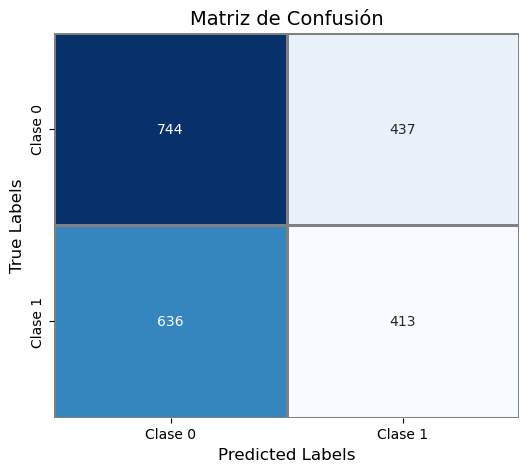

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones de probabilidad
y_pred_prob = trymodel_11.predict(val_dataset)

# Convertir a etiquetas binarias (umbral 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Obtener las etiquetas verdaderas
y_true = np.concatenate([y for x, y in val_dataset], axis=0).astype(int)
#Matriz confusion
cm = confusion_matrix(y_true, y_pred)

# Visualización con Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=1,
    linecolor='gray'
)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Matriz de Confusión', fontsize=14)
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()


In [69]:
model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_11.keras"
trymodel_11.save(model_path)

### ResNet 3.0

Aumentamos epochs

In [207]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar modelo base ResNet50 sin las capas superiores
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Congelar todas excepto las últimas 30 capas
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Construcción del modelo
trymodel_9 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

# Compilación del modelo
trymodel_9.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [208]:
# Entrenamiento
history_9 = trymodel_9.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.5216 - loss: 0.7214 - precision_16: 0.4885 - recall_16: 0.4310 - val_accuracy: 0.4591 - val_loss: 0.6999 - val_precision_16: 0.4591 - val_recall_16: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 133s 785ms/step - accuracy: 0.5439 - loss: 0.6877 - precision_16: 0.5113 - recall_16: 0.3187 - val_accuracy: 0.5986 - val_loss: 0.7011 - val_precision_16: 0.6667 - val_recall_16: 0.2234 - learning_rate: 1.0000e-04
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 125s 735ms/step - accuracy: 0.5500 - loss: 0.6913 - precision_16: 0.5454 - recall_16: 0.2926 - val_accuracy: 0.4928 - val_loss: 0.7131 - val_precision_16: 0.4706 - val_recall_16: 0.1154 - learning_rate: 1.0000e-04
Epoch 4/50
168/170 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.5918 - loss: 0.6711 - precision_16: 0.5945 - recall_16: 0.3847

c:\Users\swatc\anaconda3\envs\conda310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


170/170 ━━━━━━━━━━━━━━━━━━━━ 152s 897ms/step - accuracy: 0.5917 - loss: 0.6711 - precision_16: 0.5944 - recall_16: 0.3846 - val_accuracy: 0.6058 - val_loss: 0.6523 - val_precision_16: 0.6125 - val_recall_16: 0.2692 - learning_rate: 1.0000e-04
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 175s 874ms/step - accuracy: 0.5912 - loss: 0.6683 - precision_16: 0.5617 - recall_16: 0.4001 - val_accuracy: 0.4808 - val_loss: 0.7744 - val_precision_16: 0.4565 - val_recall_16: 0.9130 - learning_rate: 1.0000e-04
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 138s 814ms/step - accuracy: 0.5870 - loss: 0.6744 - precision_16: 0.5594 - recall_16: 0.5588 - val_accuracy: 0.5433 - val_loss: 0.7074 - val_precision_16: 0.5142 - val_recall_16: 0.9900 - learning_rate: 1.0000e-04
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6134 - loss: 0.6510 - precision_16: 0.5808 - recall_16: 0.6276
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
170/170 ━━━━━━━━━━━━━━━━━━━━ 123s 726ms/s

In [209]:
# Evaluación en test
results = trymodel_9.evaluate(test_dataset)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test Precision: {results[2] * 100:.2f}%")
print(f"Test Recall: {results[3] * 100:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.6524 - loss: 0.5758 - precision_16: 0.5743 - recall_16: 0.7956

Test Loss: 0.5756
Test Accuracy: 66.97%
Test Precision: 59.36%
Test Recall: 82.52%


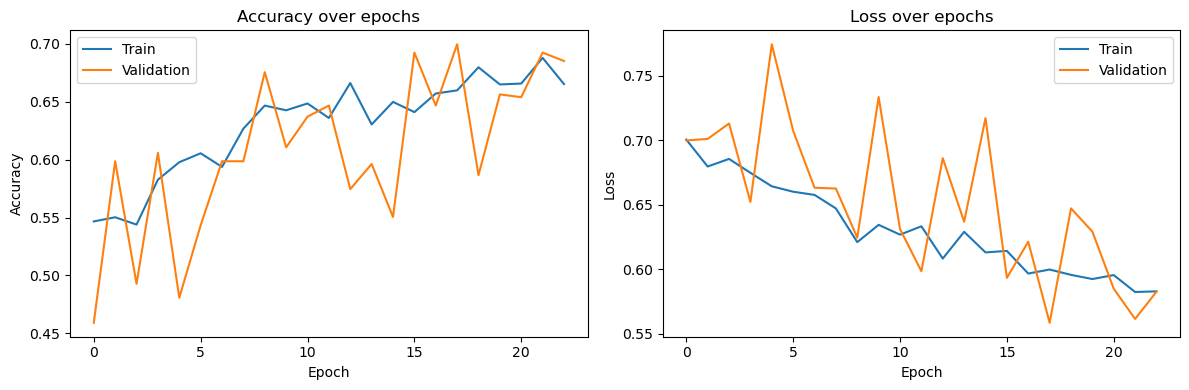

In [210]:
#Curva entrenamiento 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_9.history['accuracy'], label='Train')
plt.plot(history_9.history['val_accuracy'], label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_9.history['loss'], label='Train')
plt.plot(history_9.history['val_loss'], label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [211]:
# Guardar el modelo en formato HDF5
# Guardar el modelo en formato nativo de Keras (.keras)
model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_9.keras"
trymodel_9.save(model_path)


# #Para Cargarlo sería así:
# from tensorflow.keras.models import load_model

# model_path = r"C:\Users\swatc\Desktop\UNI\TFM\TFM\artifacts\models\trymodel_9.keras"
# trymodel_9 = load_model(model_path)